In [ ]:
# Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import inflection
import datetime


In [ ]:
# Dataset Loading

df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')


In [ ]:
# Descrição dos dados

df1 = df_raw.copy()

# Column Renaming

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Id', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [ ]:
# Data Dimensions

print("Number of Rows: ", df1.shape[0])
print("Number of Columns: ", df1.shape[1])

In [ ]:
df1.dtypes

In [ ]:
# Data Types
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d', errors='raise')


In [ ]:
df1.isna().sum()

In [ ]:
 ## 1.5. Fillout NA
             
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )




In [ ]:
## 1.6. Change Data Types
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        

In [ ]:
## 1.7. Descriptive Statistics

num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [ ]:
## 1.7.1. Numerical Atributes

# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
sns.distplot( df1['competition_distance'], kde=False )

In [ ]:
## 1.7.2. Categorical Atributes

cat_attributes.apply( lambda x: x.unique().shape[0] )
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )
plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )



In [ ]:
df2 = df1.copy()    
# Feature Engineering

# year
df2['year'] = df2['date'].dt.year

        # month
df2['month'] = df2['date'].dt.month

        # day
df2['day'] = df2['date'].dt.day

        # week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [ ]:
##3.2 2.2. Criacao das Hipoteses
#3.2.1 2.2.1. Hipoteses Loja
#1. Lojas com número maior de funcionários deveriam vender mais.
#2. Lojas com maior capacidade de estoque deveriam vender mais.
#3. Lojas com maior porte deveriam vender mais.
#4. Lojas com maior sortimentos deveriam vender mais.
#5. Lojas com competidores mais próximos deveriam vender menos.
#6. Lojas com competidores à mais tempo deveriam vendem mais.
#3.2.2 2.2.2. Hipoteses Produto
#1. Lojas que investem mais em Marketing deveriam vender mais.
#2. Lojas com maior exposição de produto deveriam vender mais.
#3. Lojas com produtos com preço menor deveriam vender mais.
#5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
#6. Lojas com promoções ativas por mais tempo deveriam vender mais.
#7. Lojas com mais dias de promoção deveriam vender mais.
#8. Lojas com mais promoções consecutivas deveriam vender mais.
#3.2.3 2.2.3. Hipoteses Tempo
#1. Lojas abertas durante o feriado de Natal deveriam vender mais.
#2. Lojas deveriam vender mais ao longo dos anos.
#3. Lojas deveriam vender mais no segundo semestre do ano.
#4. Lojas deveriam vender mais depois do dia 10 de cada mês.
#5. Lojas deveriam vender menos aos finais de semana.
#6. Lojas deveriam vender menos durante os feriados escolares.
#3.3 2.3. Lista Final de Hipóteses
#1. Lojas com maior sortimentos deveriam vender mais.
#2. Lojas com competidores mais próximos deveriam vender menos.
#3. Lojas com competidores à mais tempo deveriam vendem mais.
#4. Lojas com promoções ativas por mais tempo deveriam vender mais.
#5. Lojas com mais dias de promoção deveriam vender mais.
#7. Lojas com mais promoções consecutivas deveriam vender mais.
#8. Lojas abertas durante o feriado de Natal deveriam vender mais.
#9. Lojas deveriam vender mais ao longo dos anos.
#10. Lojas deveriam vender mais no segundo semestre do ano.
#11. Lojas deveriam vender mais depois do dia 10 de cada mês.
#12. Lojas deveriam vender menos aos finais de semana.
#13. Lojas deveriam vender menos durante os feriados escolares.


In [ ]:
df3 = df2.copy()
### Exploratory Data Analysis (EDA)
## Lojas com maior assortment deve vender mais
aux1 = df3[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
aux2 = df3[['assortment', 'sales', 'year_week']].groupby([ 'assortment' , 'year_week']).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()



In [ ]:
## Lojas com competidoress mais proximos devem vender menos
aux1 = df3[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1, alpha=0.5);
plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, width=0.1, color='blue');


plt.subplot(1, 3, 3)
numeric_cols = aux1.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_cols.corr(method='pearson'), annot=True);



In [ ]:
## Lojas com comeptidores mais antigos devem vender mais
plt.subplot( 1, 3, 1 )
aux1 = df3[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (
aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

In [ ]:
#4. Lojas com promoções ativas por mais tempo deveriam vender mais.
aux1 = df3[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[(aux1['promo_time_week'] != 0)]
plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5
plt.subplot(2, 1, 1)
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);
plt.subplot(2, 1, 2)
sns.scatterplot(x='promo_time_week', y='sales', data=aux2);

plt.tight_layout()  # Ajusta automaticamente os espaços entre os gráficos
plt.show()

In [ ]:
df3.dtypes
#Loja aberta em feriado de Natal deve vender mais
filtered = df3[(df3['open'] == 1) & (df3['state_holiday'] != 'regular_day')]
aux1 = filtered[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

#falso


In [ ]:
#9. Lojas deveriam vender mais ao longo dos anos.
aux1 = df3[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'));

#Falso

In [ ]:
# Lojas deveriam vender mais no segundo semestre do ano.
aux1 = df3[['month', 'sales']].groupby('month').sum().reset_index()
plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'));



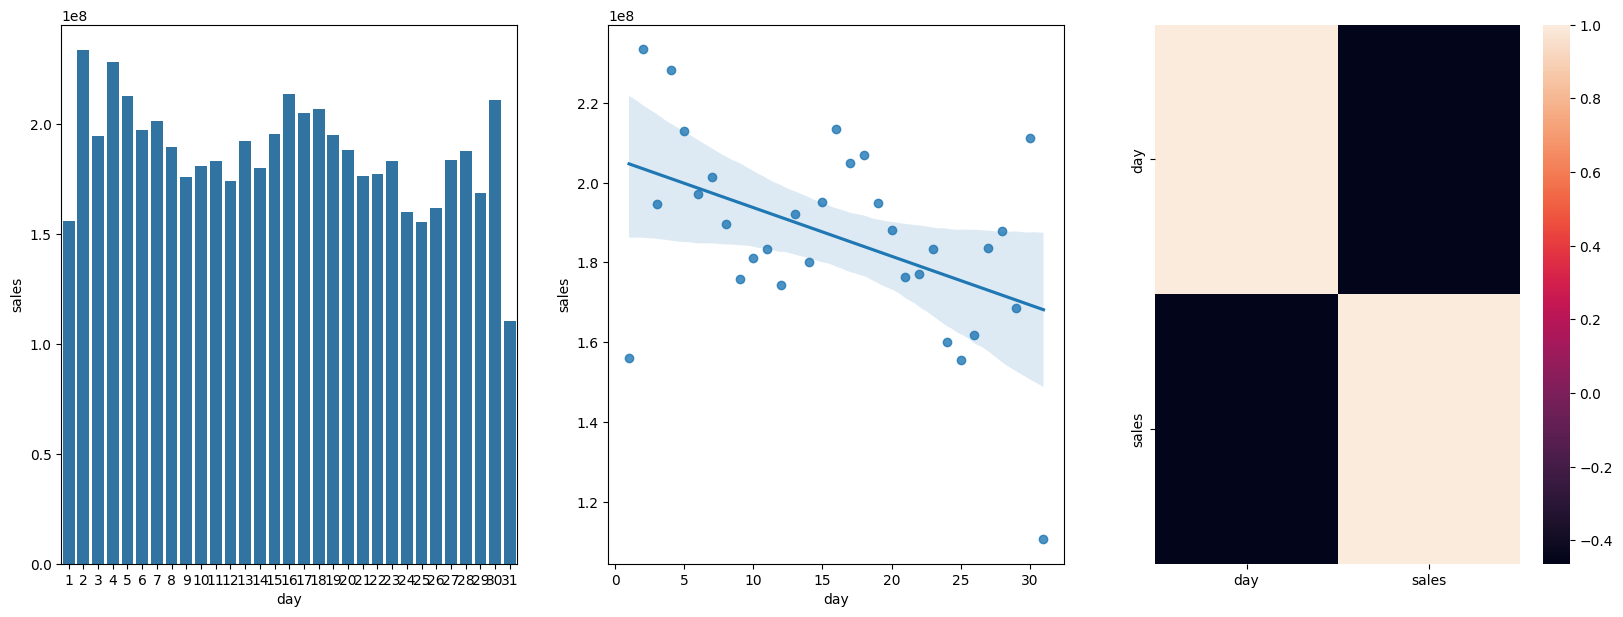

In [28]:
#11. Lojas deveriam vender mais depois do dia 10 de cada mês.
aux1 = df3[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5
plt.subplot(1, 3, 1)
sns.barplot(x='day', y='sales', data=aux1);
plt.subplot(1, 3, 2)
sns.regplot(x='day', y='sales', data=aux1);
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'));

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'id', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')